In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller, acf
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf
import pyfolio as pf

In [46]:
tickers = ['TCS.BO', 'WIPRO.BO', 'HDFCBANK.BO', 'ICICIBANK.BO', 'RELIANCE.NS','^NSEBANK','^NSEI','HINDUNILVR.NS', 'ASIANPAINT.NS']

df = yf.download(tickers)
df = df.iloc[-2500:]
df = df['Adj Close']
df.dropna(inplace=True)
df.columns = ['ASIANPAINT', 'HDFCBANK', 'HINDUNILVR', 'ICICIBANK','RELIANCE', 'TCS', 'WIPRO', 'NSEBANK', 'NSEI']
df.head()

[*********************100%***********************]  9 of 9 completed


,ASIANPAINT,HDFCBANK,HINDUNILVR,ICICIBANK,RELIANCE,TCS,WIPRO,NSEBANK,NSEI
Date,,,,,,,,,
2013-09-27,435.776581,283.395508,519.277954,143.916138,390.447327,772.758911,155.119370,9899.634766,5833.200195
2013-09-30,425.990692,275.935883,524.671448,137.938461,382.312012,764.642944,154.760254,9617.688477,5735.299805
2013-10-01,421.445587,284.301788,517.772827,141.998932,381.870392,772.123901,153.650269,9883.184570,5780.049805
2013-10-03,436.704193,295.665497,509.787323,146.191849,393.724670,803.178650,158.171814,10222.831055,5909.700195
2013-10-04,433.272186,297.617493,507.362183,145.030624,397.187988,806.750488,157.649445,10197.032227,5907.299805


In [47]:
df.corr()

,ASIANPAINT,HDFCBANK,HINDUNILVR,ICICIBANK,RELIANCE,TCS,WIPRO,NSEBANK,NSEI
ASIANPAINT,1.000000,0.930405,0.939529,0.949979,0.968699,0.973503,0.883592,0.921292,0.971996
HDFCBANK,0.930405,1.000000,0.961530,0.882982,0.931536,0.940114,0.790544,0.959212,0.940589
HINDUNILVR,0.939529,0.961530,1.000000,0.879480,0.951657,0.940509,0.759880,0.903540,0.912378
ICICIBANK,0.949979,0.882982,0.879480,1.000000,0.914235,0.923285,0.795968,0.943703,0.974656
RELIANCE,0.968699,0.931536,0.951657,0.914235,1.000000,0.969699,0.843889,0.890214,0.943708
TCS,0.973503,0.940114,0.940509,0.923285,0.969699,1.000000,0.900500,0.912238,0.960966
WIPRO,0.883592,0.790544,0.759880,0.795968,0.843889,0.900500,1.000000,0.765881,0.853683
NSEBANK,0.921292,0.959212,0.903540,0.943703,0.890214,0.912238,0.765881,1.000000,0.973566
NSEI,0.971996,0.940589,0.912378,0.974656,0.943708,0.960966,0.853683,0.973566,1.000000


**Strategy:**<br>

**Portfolio is Buy First Stock and Sell Second Stock** <br>

**Buy portfolio when difference between spread and mean of spread of last 10 days <= 2 std dev below mean <br>**
Target = 1 std dev above mean <br>
Stoploss = 3 std below mean <br>

**Sell portfolio when spread_mean_diff and mean of spread of last 10 days >= 2 std dev above mean <br>**
Target = 1 std dev below mean <br>
Stoploss = 3 std above mean

In [48]:
def ad_fuller_test(x,y):
    
    model = sm.OLS(x, y).fit()
    hedge_ratio = model.params[0]
    print("Hedge Ratio:", hedge_ratio)
    spread = x - hedge_ratio * y
    adf = adfuller(spread)
    print("T-stat: ",adf[0])
    print("p value: ",adf[1])
    if adf[1] < 0.05:
        print("The series is stationary")
    else:
        print("The series is non stationary")

    plt.figure(figsize=(10,8))
    plt.plot(spread)
    plt.legend()
    plt.grid(True)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [49]:
def prepare_data(data, col1, col2):
    
    model = sm.OLS(data[col1], data[col2]).fit()
    hedge_ratio = model.params[0]
    data['spread'] = data[col1] - hedge_ratio * data[col2]
    data['spread_mean'] = data['spread'].rolling(window=10).mean()
    data['spread_mean_diff'] = data['spread'] - data['spread_mean']
    data['spread_mean_diff_shift'] = data['spread_mean_diff'].shift()
    data['mean'] = data['spread_mean_diff'].rolling(window=10).mean()
    data['std'] = data['spread_mean_diff'].rolling(window=10).std()
    
    data['lower1_band'] = data['mean'] - data['std']
    data['upper1_band'] = data['mean'] + data['std']
    
    data['lower2_band'] = data['mean'] - 2 * data['std']
    data['upper2_band'] = data['mean'] + 2 * data['std']
    
    data['lower3_band'] = data['mean'] - 3 * data['std']
    data['upper3_band'] = data['mean'] + 3 * data['std']
    
    ad_fuller_test(data['spread_mean_diff'].iloc[10:], data['spread_mean_diff_shift'].iloc[10:])
    return data

In [50]:
def set_long_position(row, prev_state):
    if row['long_signal'] == 1:
        return 1
    elif row['long_signal'] == -1:
        return 0
    else:
        return prev_state

In [51]:
def set_short_position(row, prev_state):
    if row['short_signal'] == -1:
        return -1
    elif row['short_signal'] == 1:
        return 0
    else:
        return prev_state

In [52]:
def pair_trade(training_data):
    
    training_data['long_signal'] = np.where((training_data['spread_mean_diff'] <= training_data['lower2_band']) & (training_data['spread_mean_diff_shift'] > training_data['lower2_band']), 1, 0)
    training_data['long_signal'] = np.where((training_data['spread_mean_diff'] >= training_data['upper1_band']) & (training_data['spread_mean_diff_shift'] < training_data['upper1_band']), -1, training_data['long_signal'])
    training_data['long_signal'] = np.where((training_data['spread_mean_diff'] <= training_data['lower3_band']) & (training_data['spread_mean_diff_shift'] > training_data['lower3_band']), -1, training_data['long_signal'])
    
    training_data['short_signal'] = np.where((training_data['spread_mean_diff'] >= training_data['upper2_band']) & (training_data['spread_mean_diff_shift'] < training_data['upper2_band']), -1, 0)
    training_data['short_signal'] = np.where((training_data['spread_mean_diff'] <= training_data['lower1_band']) & (training_data['spread_mean_diff_shift'] > training_data['lower1_band']), 1, training_data['short_signal']) 
    training_data['short_signal'] = np.where((training_data['spread_mean_diff'] >= training_data['upper3_band']) & (training_data['spread_mean_diff_shift'] < training_data['upper3_band']), -1, training_data['short_signal'])
    
    training_data['long_signal'] = training_data['long_signal'].shift()
    training_data['short_signal'] = training_data['short_signal'].shift()
    
    training_data['long_position'] = 0
    prev_state = 0
    for i, row in training_data.iterrows():
        training_data.at[i, 'long_position'] = set_long_position(row, prev_state)
        prev_state = training_data.at[i, 'long_position']
        
    training_data['short_position'] = 0
    prev_state = 0
    for i, row in training_data.iterrows():
        training_data.at[i, 'short_position'] = set_short_position(row, prev_state)
        prev_state = training_data.at[i, 'short_position']
        
    return training_data

In [53]:
def analyse_data(training_data, col1, col2):

    model = sm.OLS(data[col1], data[col2]).fit()
    hedge_ratio = model.params[0]
    training_data['cc_returns'] = np.round((training_data['spread'] - training_data['spread'].shift(1))/(training_data[col1] + hedge_ratio * training_data[col2]),4)
    training_data['returns'] = np.round((training_data['cc_returns'] * (training_data['long_position'] + training_data['short_position'])),4)
    training_data['cumsum'] = np.round(training_data['returns'].cumsum(),4)

    pf.create_simple_tear_sheet(training_data['returns'])
    return training_data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedge Ratio: 0.8614657752684501
T-stat:  -35.541299989316386
p value:  0.0
The series is stationary


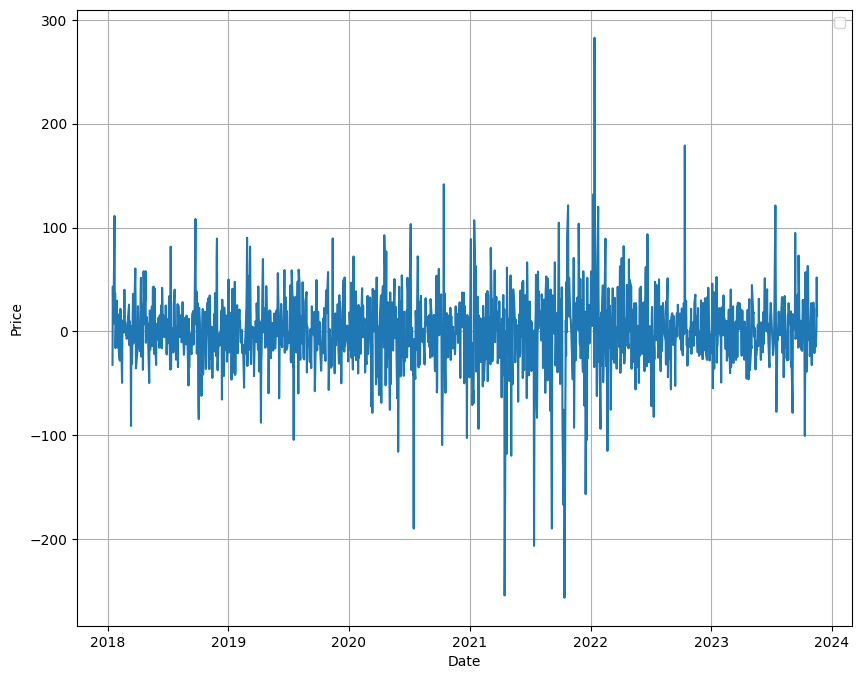

Start date,2018-01-02
End date,2022-02-03
Total months,47
,Backtest
Annual return,-6.1%
Cumulative returns,-22.2%
Annual volatility,9.9%
Sharpe ratio,-0.59
Calmar ratio,-0.19
Stability,0.01
Max drawdown,-31.7%


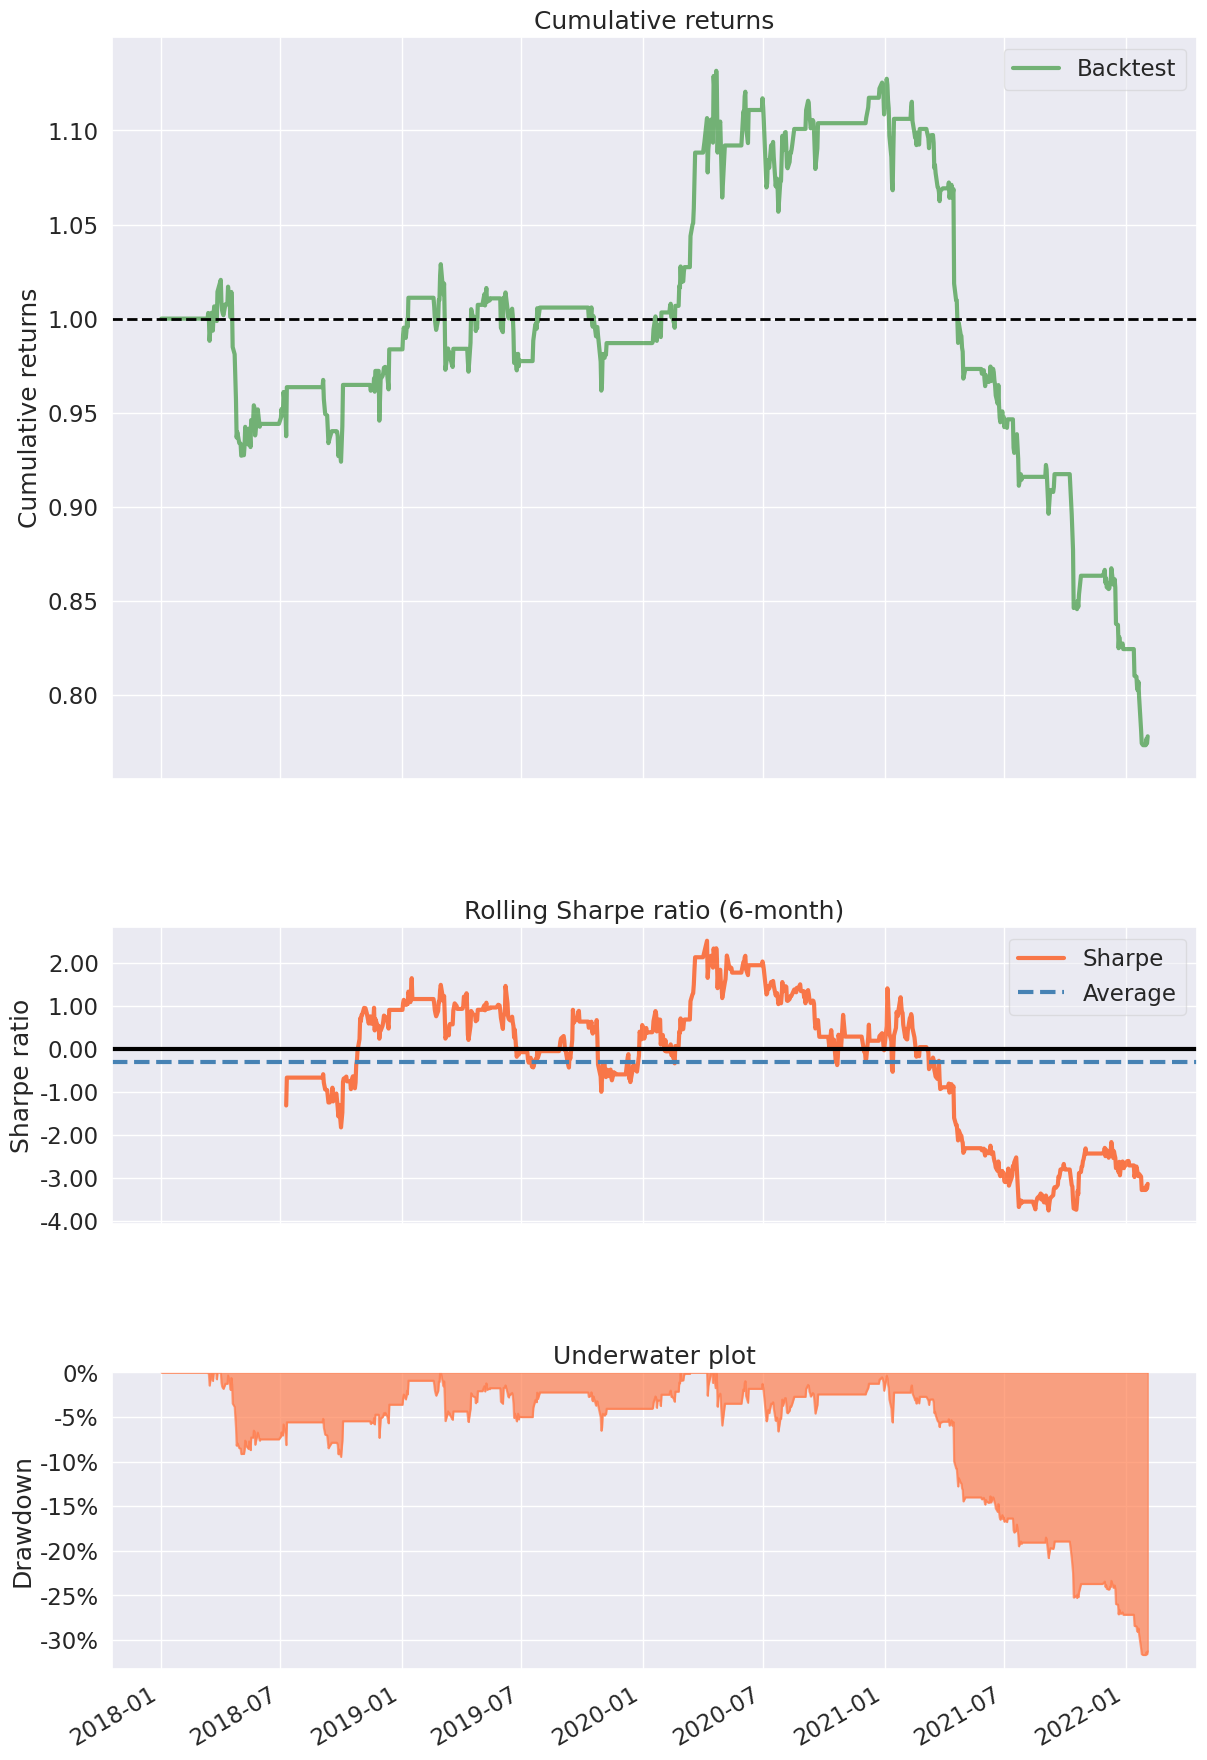

In [54]:
df_it = df[['TCS','WIPRO']].loc['2018-01-01':]
df_it = prepare_data(df_it,'TCS','WIPRO')
training_data = df_it[:1000]
data = pair_trade(training_data)
data = analyse_data(data,'TCS','WIPRO')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedge Ratio: 0.7927004696519696
T-stat:  -12.33014195683489
p value:  6.454505121456666e-23
The series is stationary


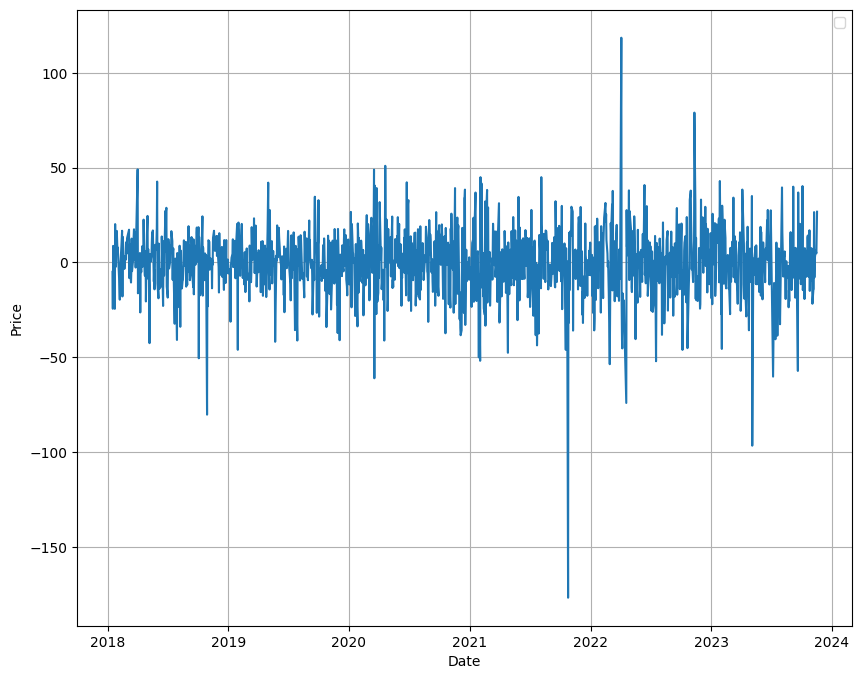

Start date,2018-01-02
End date,2022-02-03
Total months,47
,Backtest
Annual return,6.5%
Cumulative returns,28.3%
Annual volatility,7.9%
Sharpe ratio,0.83
Calmar ratio,0.45
Stability,0.84
Max drawdown,-14.3%


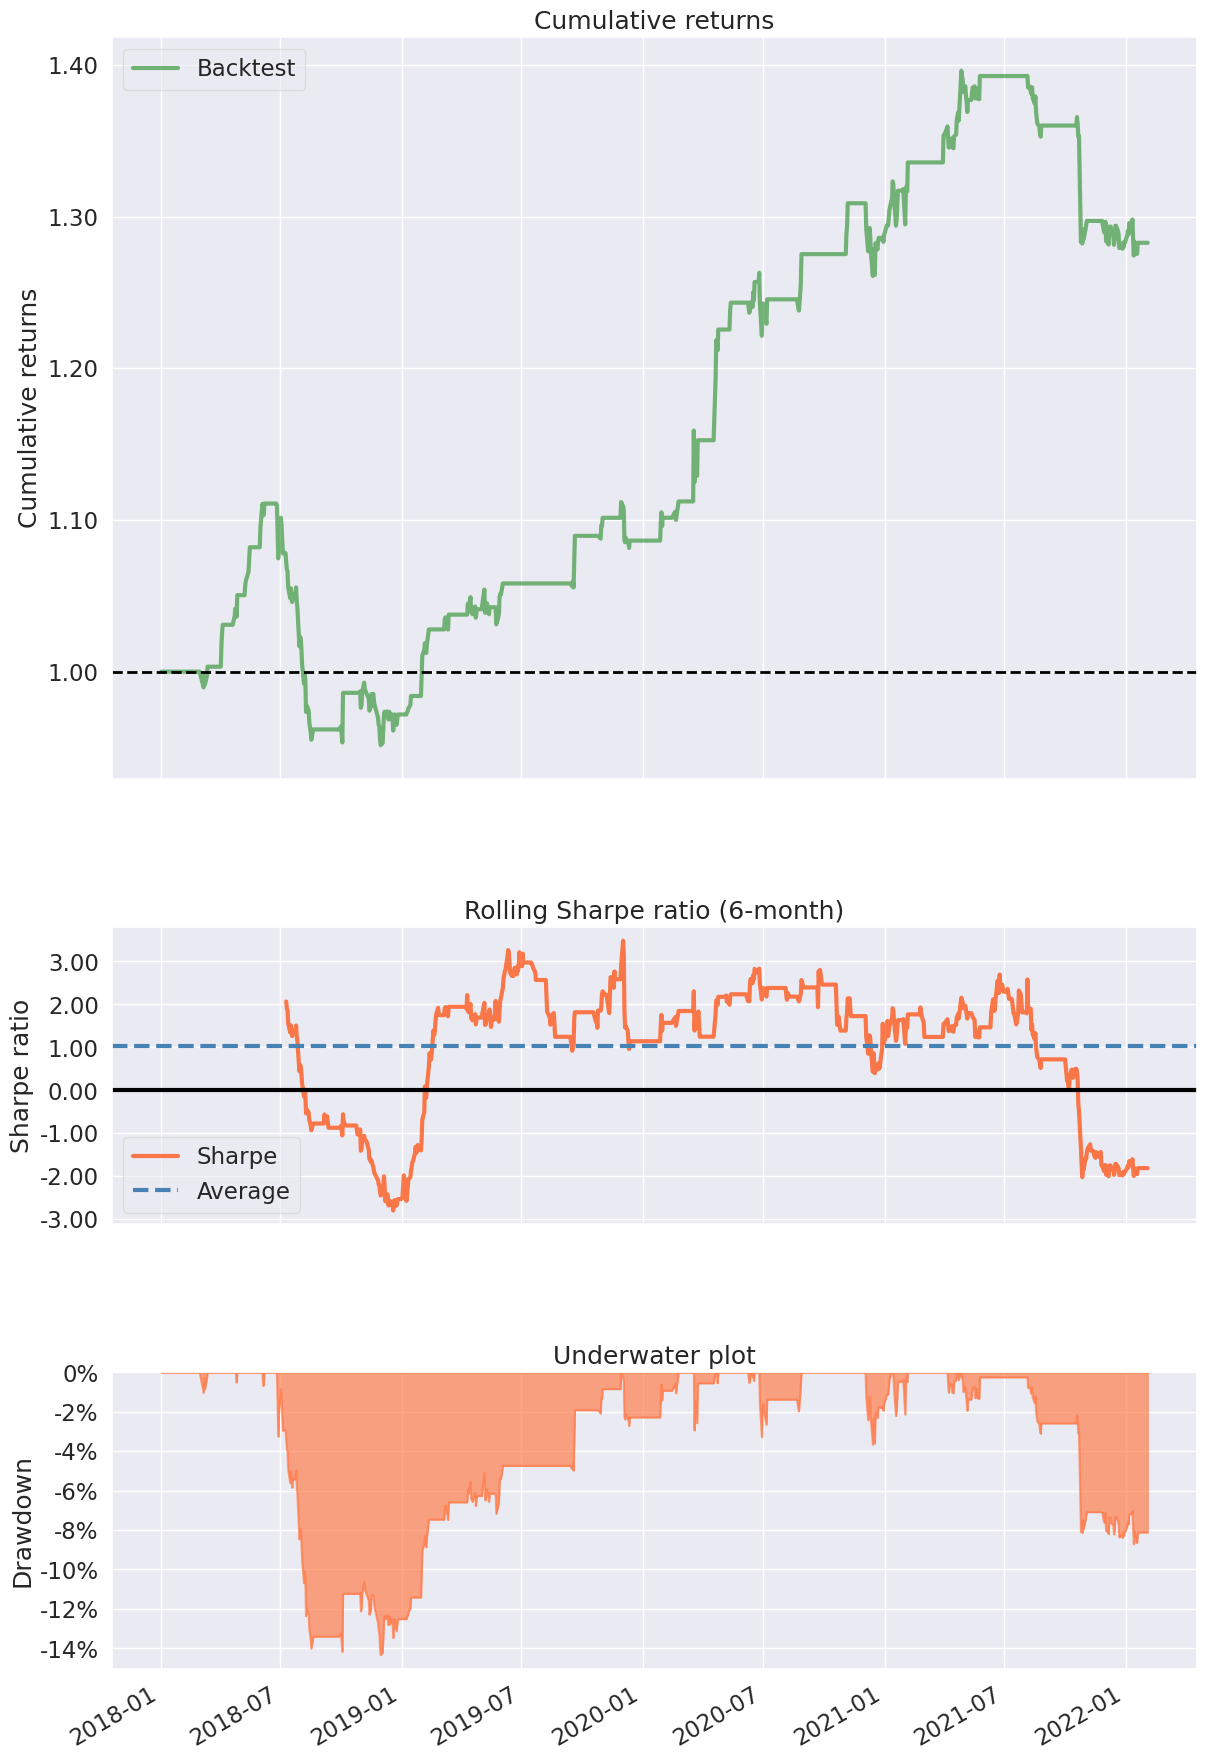

In [55]:
df_bank = df[['HDFCBANK','ICICIBANK']].loc['2018-01-01':]
df_bank = prepare_data(df_bank,'HDFCBANK','ICICIBANK')
training_data = df_bank[:1000]
data = pair_trade(training_data)
data = analyse_data(data,'HDFCBANK','ICICIBANK')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedge Ratio: 0.8636507031470002
T-stat:  -14.112078951842362
p value:  2.509562563449131e-26
The series is stationary


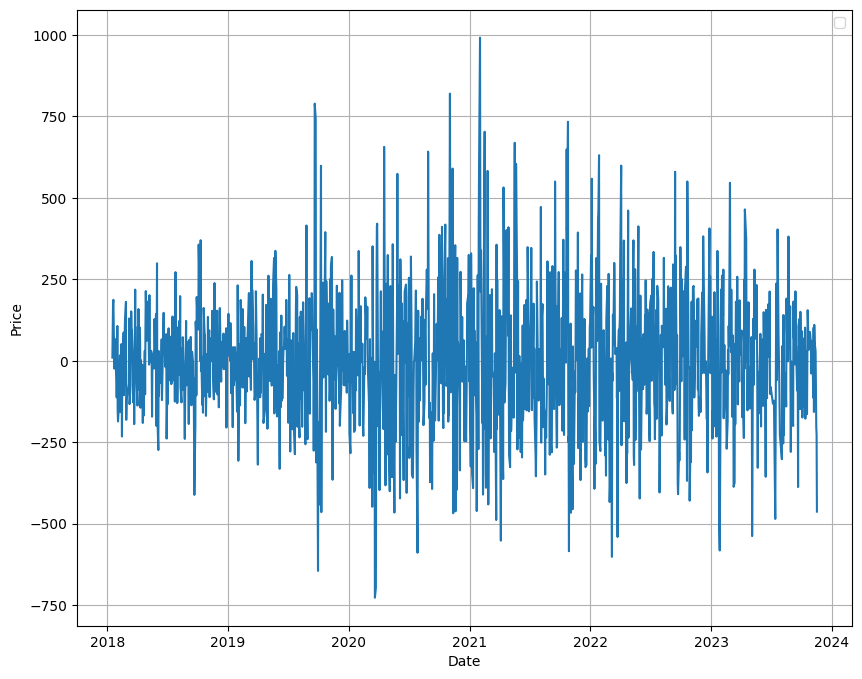

Start date,2018-01-02
End date,2022-02-03
Total months,47
,Backtest
Annual return,-1.3%
Cumulative returns,-5.2%
Annual volatility,3.9%
Sharpe ratio,-0.33
Calmar ratio,-0.14
Stability,0.55
Max drawdown,-9.9%


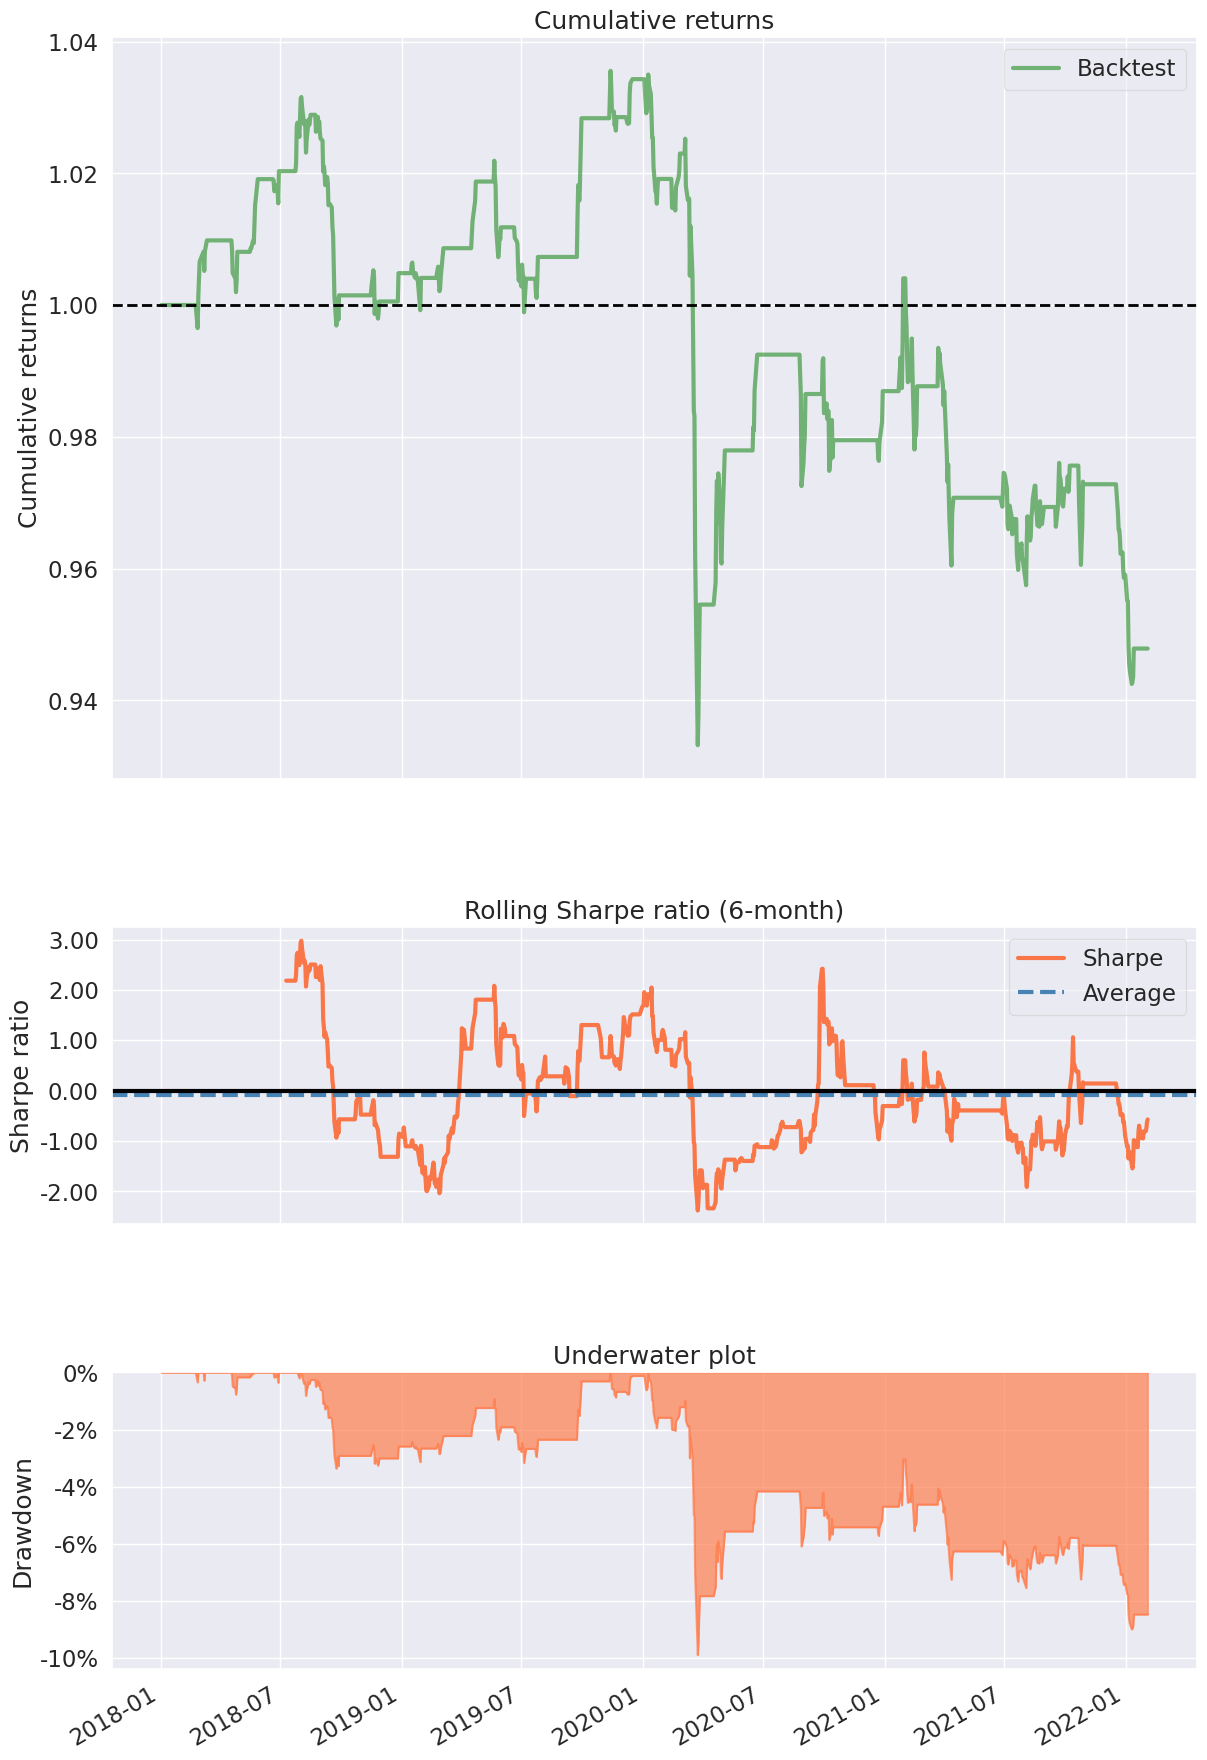

In [57]:
df_index = df[['NSEBANK','NSEI']].loc['2018-01-01':]
df_index = prepare_data(df_index,'NSEBANK','NSEI')
training_data = df_index[:1000]
data = pair_trade(training_data)
data = analyse_data(data,'NSEBANK','NSEI')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedge Ratio: 0.8158905904114826
T-stat:  -13.176101524025018
p value:  1.2224489596563923e-24
The series is stationary


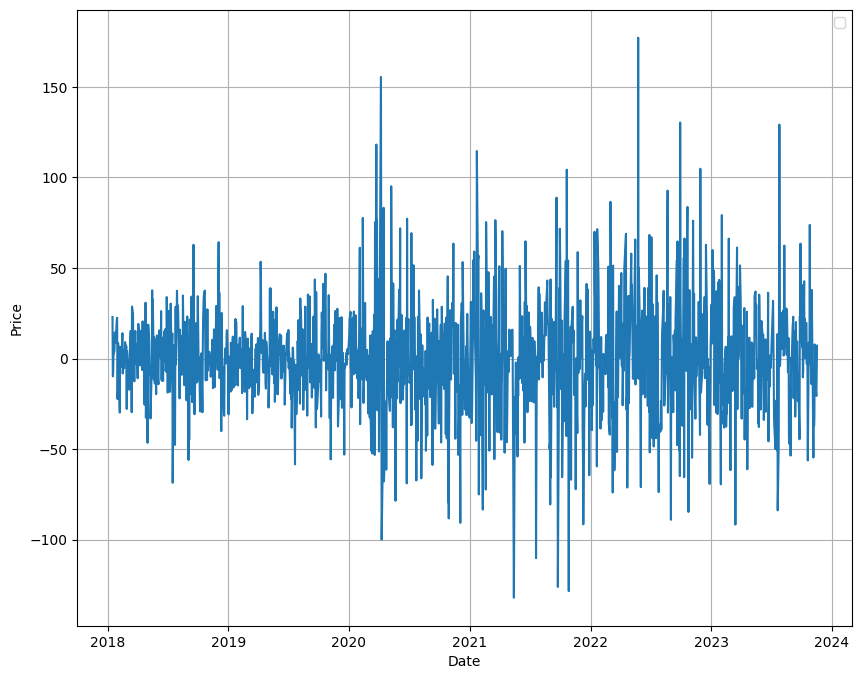

Start date,2018-01-02
End date,2022-02-03
Total months,47
,Backtest
Annual return,-0.9%
Cumulative returns,-3.6%
Annual volatility,8.7%
Sharpe ratio,-0.06
Calmar ratio,-0.05
Stability,0.44
Max drawdown,-16.8%


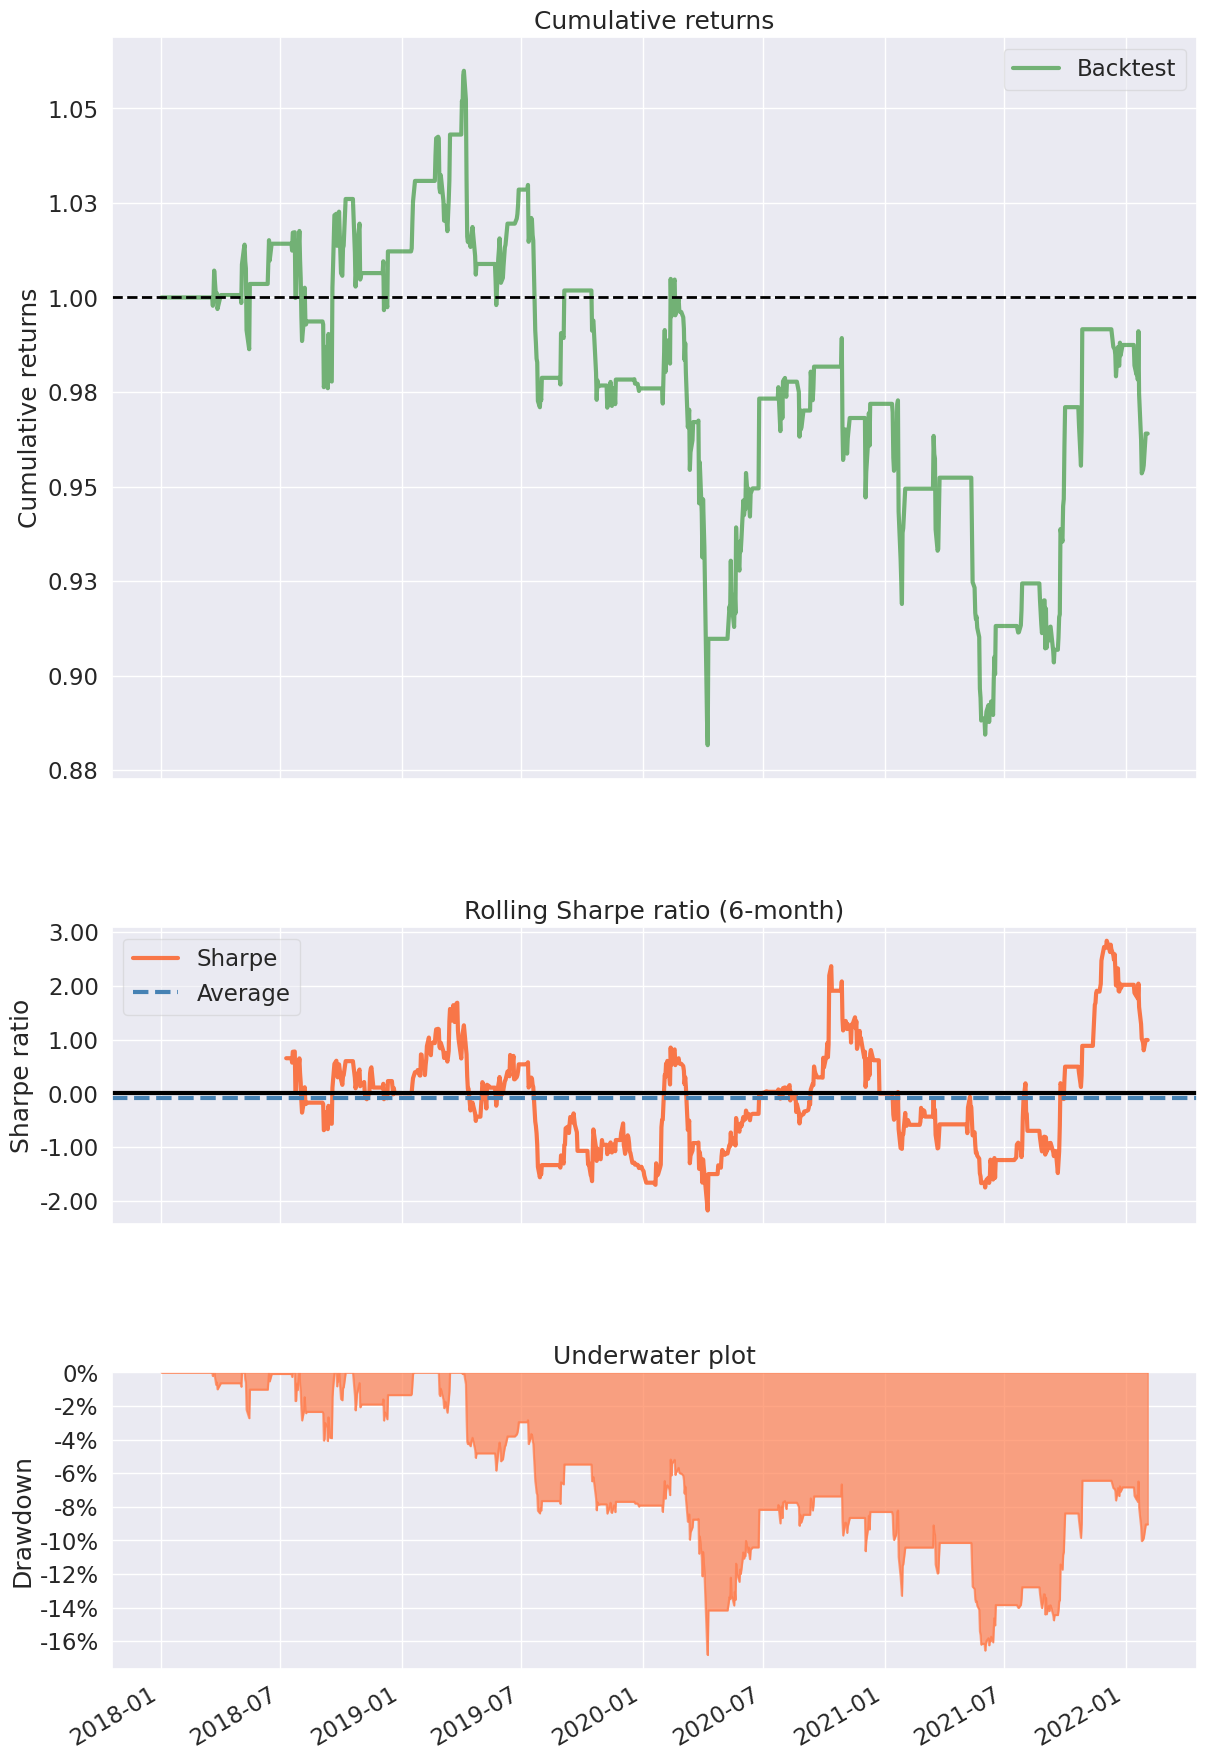

In [58]:
df_fmcg = df[['HINDUNILVR', 'ASIANPAINT']].loc['2018-01-01':]
df_fmcg = prepare_data(df_fmcg,'HINDUNILVR', 'ASIANPAINT')
training_data = df_fmcg[:1000]
data = pair_trade(training_data)
data = analyse_data(data,'HINDUNILVR', 'ASIANPAINT')